In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

## Prepair Data

In [50]:
df_all = pd.read_csv("Small LCL Data/LCL-June2015v2_0.csv")


# check no TOU sites included
TOU_values = sum(sum([df_all["stdorToU"] != "Std"]))
print(f"{TOU_values} TOU values in the data set")

# Check for null values and replace with zero
null_values = sum(df_all["KWH/hh (per half hour) "] == "Null")
df_all["KWH/hh (per half hour) "][df_all["KWH/hh (per half hour) "] == "Null"] = 0
print(f"Replaced {null_values} Null Values with zero")

0 TOU values in the data set
Replaced 29 Null Values with zero


In [51]:
df_all.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0


In [52]:
def select_site(df, id):
    df_out = df[df["LCLid"]==id]
    
    return df_out

In [53]:
def process_data(df_in):
    
    df = df_in.copy()
    
    # convert to datetime
    df['DateTime'] = df['DateTime'].astype('datetime64[s]')
    df["KWH/hh (per half hour) "] = df["KWH/hh (per half hour) "].astype(np.float16) 
    
    ## HHrly and Daily resample
    df.set_index("DateTime", inplace=True)
    #remove 1970 dates
    df = df[df.index > np.datetime64('2005-02-25')]
    
    df_hhrly = df.resample('30T').sum()
    df_daily = df.resample('24H').sum()

    df_hhrly.reset_index(level=0, inplace=True)
    df_daily.reset_index(level=0, inplace=True)
    
    df_hhrly = df_hhrly.rename(columns={"DateTime": "ts", "KWH/hh (per half hour) ": "energy_kWh"})
    df_daily = df_daily.rename(columns={"DateTime": "ts", "KWH/hh (per half hour) ": "energy_kWh"})
    
    return df_hhrly, df_daily

In [54]:
def select_dates(df_in, train_start, train_end, test_start, test_end):
    
    
    df = df_in.copy()
    df.set_index("ds", inplace=True)
    df_train = df[pd.to_datetime(train_start) : pd.to_datetime(train_end)]
    df_test = df[pd.to_datetime(test_start) : pd.to_datetime(test_end)]
    df_train.reset_index(level=0, inplace=True)
    df_test.reset_index(level=0, inplace=True)
    
    return df_train, df_test


In [55]:
df_all.LCLid.unique()

array(['MAC000002', 'MAC000003', 'MAC000004', 'MAC000006', 'MAC000007',
       'MAC000008', 'MAC000009', 'MAC000010', 'MAC000011', 'MAC000012',
       'MAC000013', 'MAC000016', 'MAC000018', 'MAC000019', 'MAC000020',
       'MAC000021', 'MAC000022', 'MAC000023', 'MAC000024', 'MAC000025',
       'MAC000026', 'MAC000027', 'MAC000028', 'MAC000029', 'MAC000030',
       'MAC000032', 'MAC000033', 'MAC000034', 'MAC000035', 'MAC000036'],
      dtype=object)

In [56]:
# get site
# df1 = select_site(df_all, id="MAC000009")
df1 = select_site(df_all, id="MAC000013")
#df1 = select_site(df_all, id="MAC000021")

In [57]:
# process data
df_hhrly, df_daily = process_data(df1)

In [58]:
def check_time_series_complete(ts, freq):
    """ freq: e.g 'H' or '0.5H' """
    
    print(f"Data range: from {ts.min()} to {ts.max()}")

    ts_complete = pd.date_range(ts.min(), ts.max(), freq=freq)
    
    print(f"Length of ideal ts: {ts_complete.shape[0]}, "
          f"data ts: {ts.shape[0]}")

    if sum(ts_complete != ts) == 0:
        print("Data ts and ideal ts values are the same")
    else:
        print("Data ts and ideal ts values differ")

In [59]:
check_time_series_complete(df_daily.ts, freq="24H")

Data range: from 2012-06-21 00:00:00 to 2014-02-28 00:00:00
Length of ideal ts: 618, data ts: 618
Data ts and ideal ts values are the same


Text(0.5, 1.0, 'Daily Energy Use kWh')

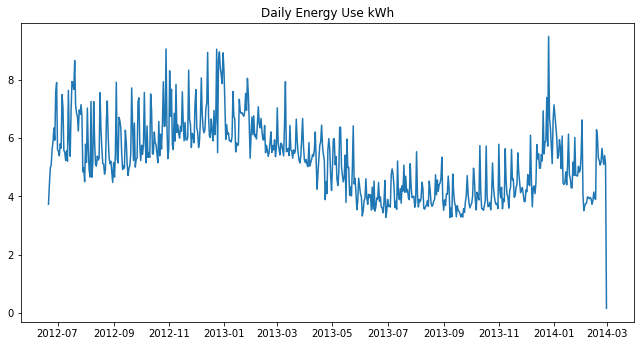

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(11, 5.5))
ax1.plot(df_daily["ts"], df_daily["energy_kWh"])
ax1.set_title("Daily Energy Use kWh")

## Simple Linear Regression

In [27]:
# Create time dummy and Lag features

df_daily["time_dummy"] = np.arange(df_daily.shape[0])
df_daily["Lag_1"] = df_daily["energy_kWh"].shift(1)

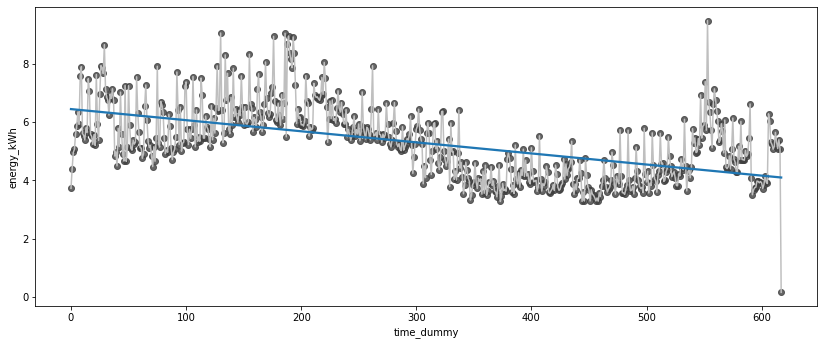

In [28]:
# Quick visualisation - Linear regression with seaborn

fig, ax = plt.subplots(figsize=(14, 5.5))
ax.plot("time_dummy", "energy_kWh", data=df_daily, color="0.75")
ax = sns.regplot(x="time_dummy", y="energy_kWh", data=df_daily, ci=None,
                scatter_kws=dict(color="0.25"))

### Proper linear fit using sklearn
 - We don't expect there to be any linear trend

## Test the feature factory

In [60]:
from forecasters import feature_factory as ff

In [157]:
import importlib
importlib.reload(ff)

<module 'forecasters.feature_factory' from '/home/shem/repos/eforecast/forecasters/feature_factory.py'>

In [158]:
factory = ff.FeatureFactory(df_daily["energy_kWh"], df_daily["ts"])

In [142]:
X_trend = factory.create_time_trend_features(order=1)
X_trend

Creating time trend features of order: 1


,const,trend
ts,,
2012-06-21,1.0,1.0
2012-06-22,1.0,2.0
2012-06-23,1.0,3.0
2012-06-24,1.0,4.0
2012-06-25,1.0,5.0
...,...,...
2014-02-24,1.0,614.0
2014-02-25,1.0,615.0
2014-02-26,1.0,616.0


In [143]:
X_lag = factory.create_lag_features(lag_steps=1)
X_lag

,y
ts,
2012-06-21,NaN
2012-06-22,3.730469
2012-06-23,4.398438
2012-06-24,4.964844
2012-06-25,5.070312
...,...
2014-02-24,5.648438
2014-02-25,5.328125
2014-02-26,5.093750


In [164]:
X_seasonal = factory.create_fourier_features(freq="y", fourier_order=12)
#X_seasonal

Creating seasonal features for Fourier freq: y and Fourier order: 12


In [183]:
X_all = factory.combine_features([X_trend, X_lag, X_seasonal])

In [184]:

# this uses feature factory


In [185]:
from sklearn.linear_model import LinearRegression

df = df_daily.set_index(X_all.index, drop=True)

X_all = X_all.dropna(axis=0)

y = df.loc[:, "energy_kWh"][1:]



# Train mode
model = LinearRegression()
model.fit(X_all, y)

# Store fitted values a new time series
y_pred = pd.Series(model.predict(X_all), index=X_all.index)



In [29]:
# from sklearn.linear_model import LinearRegression

# X = df_daily.loc[:, ["time_dummy"]] # creates column of data, i.e. a df rather than a series
# y = df_daily.loc[:, "energy_kWh"]

# # Train mode
# model = LinearRegression()
# model.fit(X, y)

# # Store fitted values a new time series
# y_pred = pd.Series(model.predict(X), index=X.index)

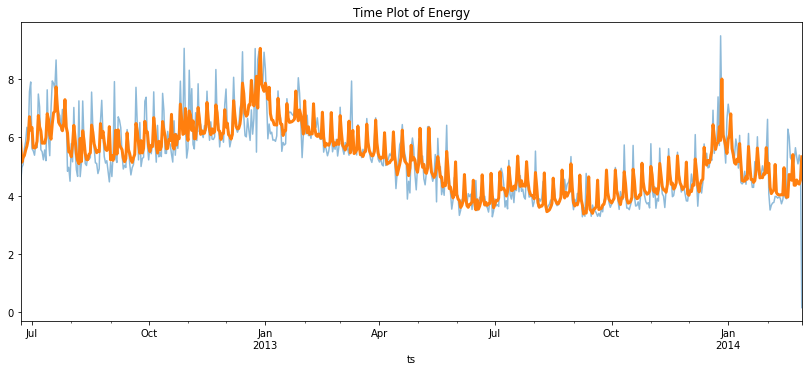

/home/shem/.pyenv/versions/3.8.8/envs/test_env/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- cos(1,freq=A-DEC)
- cos(10,freq=A-DEC)
- cos(11,freq=A-DEC)
- cos(12,freq=A-DEC)
- cos(2,freq=A-DEC)
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 7 features, but LinearRegression is expecting 34 features as input.

In [186]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title("Time Plot of Energy")
plt.show()

print(f"score: {model.score(X, y)}")
print(f"coeff: {model.coef_}") 
print(f"intercept: {model.intercept_}")

### Fit to lag_1 - i.e. is today's usage correlated to yesterday's

In [17]:
# We already added the lag above

# drop na
df_daily = df_daily.dropna()
X = df_daily.loc[:, ["Lag_1"]]
y = df_daily.loc[:, "energy_kWh"]

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

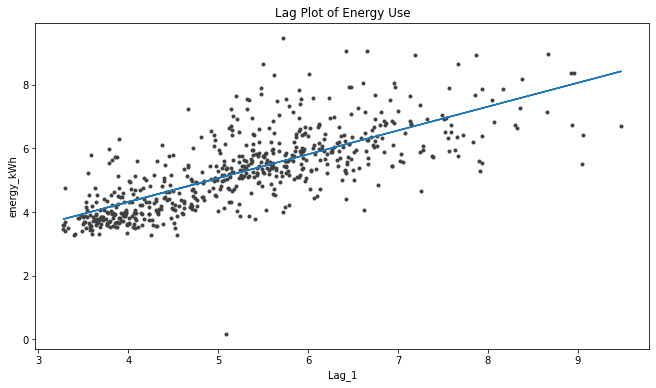

score: 0.5472236738566167
coeff: [0.74894076]
intercept: 1.321813580297384


In [18]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(X["Lag_1"], y, ".", color="0.25")
ax.plot(X["Lag_1"], y_pred)
ax.set(ylabel="energy_kWh", xlabel="Lag_1", 
       title="Lag Plot of Energy Use")
plt.show()

print(f"score: {model.score(X, y)}")
print(f"coeff: {model.coef_}") 
print(f"intercept: {model.intercept_}")

In [19]:
# Nice way to reuse plot params

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(18, 7)
)

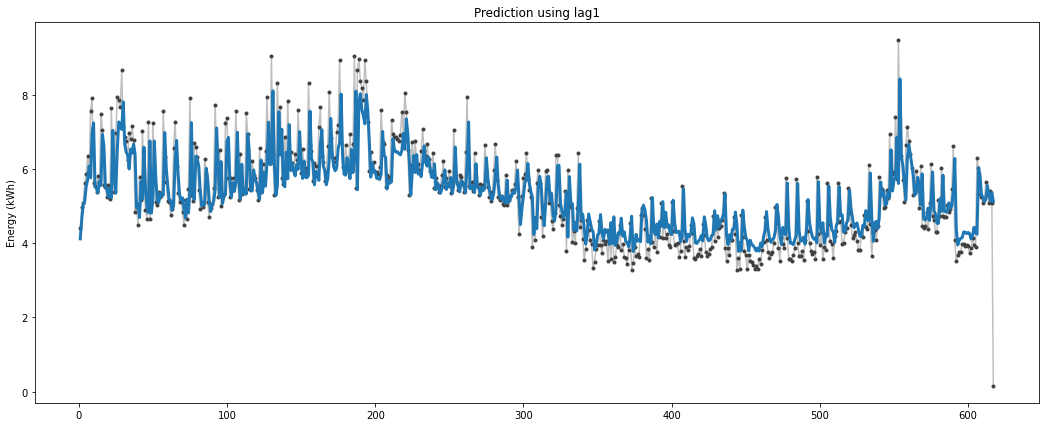

In [20]:
ax = df_daily["energy_kWh"].plot(**plot_params)

ax.set(title="Prediction using lag1",
      ylabel="Energy (kWh)")

ax = y_pred.plot(ax=ax, linewidth=3)

## Trend
 - Do some more sophisticated trend fitting

In [21]:
# Nice way to reuse plot params

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(18, 7)
)

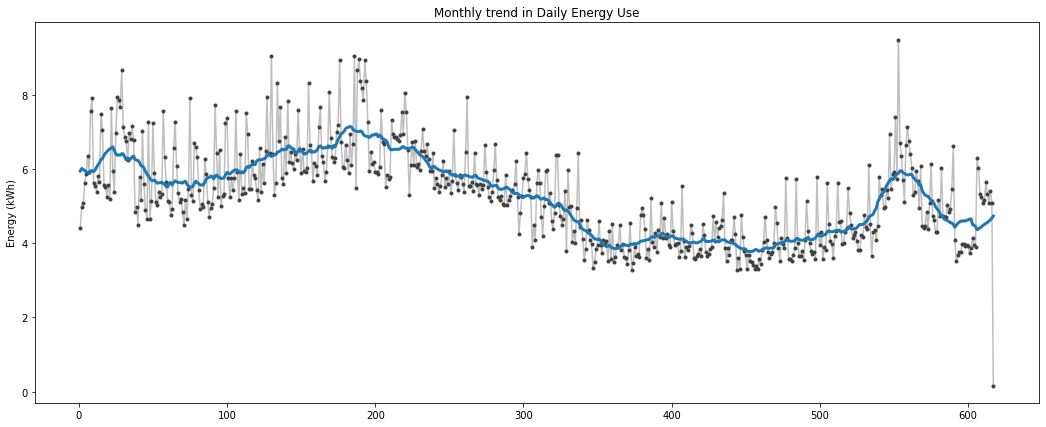

In [22]:
ax = df_daily["energy_kWh"].plot(**plot_params)

ax.set(title="Monthly trend in Daily Energy Use",
      ylabel="Energy (kWh)")

trend = df_daily["energy_kWh"].rolling(window=30,
                               center=True,
                               min_periods=3).mean()

ax = trend.plot(ax=ax, linewidth=3)

The trend here just looks like it's due to seasonal variation but lets have a go at representing it with lin regression anyway

### 3b. Create a Trend Feature

- Use DeterministicProcess to create feature
- Create a 90 day forecast

In [23]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = df_daily.energy_kWh.copy() # the target

# Instantiate with cubic trend
dp = DeterministicProcess(index=y.index,
                          constant=False, # not sure why false this time
                          order=4,
                          drop=True)

# Create feature set for dates in y.index with cubic trend
X = dp.in_sample()

# Create features for 90 day forecast
X_fore = dp.out_of_sample(steps=90)

In [24]:
X

,trend,trend_squared,trend_cubed,trend**4
1,1.0,1.0,1.0,1.000000e+00
2,2.0,4.0,8.0,1.600000e+01
3,3.0,9.0,27.0,8.100000e+01
4,4.0,16.0,64.0,2.560000e+02
5,5.0,25.0,125.0,6.250000e+02
...,...,...,...,...
613,613.0,375769.0,230346397.0,1.412023e+11
614,614.0,376996.0,231475544.0,1.421260e+11
615,615.0,378225.0,232608375.0,1.430542e+11
616,616.0,379456.0,233744896.0,1.439869e+11


score: 0.4623098974473421
coeff: [ 2.39870765e-02 -1.33804623e-04  1.98112241e-07 -6.99940861e-11]
intercept: 5.251618645263662


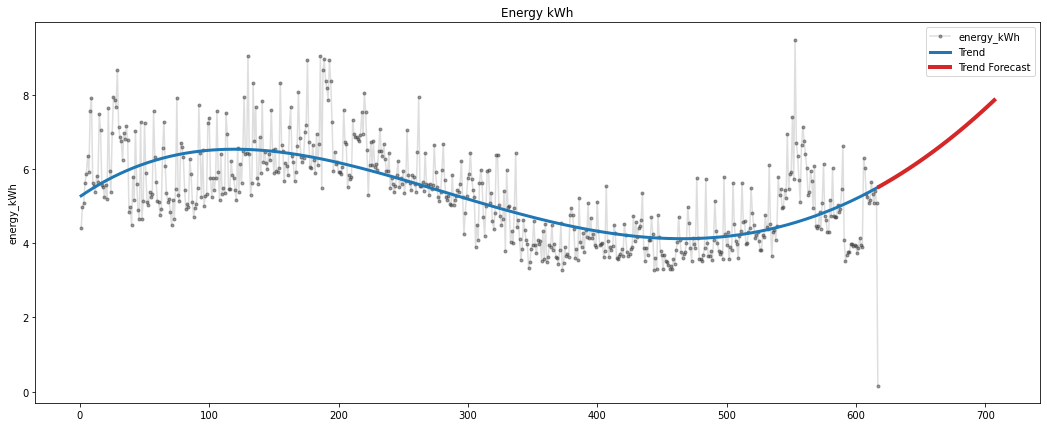

In [25]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Energy kWh", ylabel="energy_kWh")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax = y_fore.plot(ax=ax, linewidth=4, label="Trend Forecast", color="C3")
ax.legend()

print(f"score: {model.score(X, y)}")
print(f"coeff: {model.coef_}") 
print(f"intercept: {model.intercept_}")

 - We can fit this very nicely with order 4 poly but it's clearly going to abs rubbish at predicting future, this is where the seasonal features will help us!

## Seasonality

In [26]:
# Set up some plotting logic

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Create a seasonal plot, we can pass it an axis obj if we have one, if note we create one here
# Really like this, I think it allows us to build up overlay plots while plotting using a plot function

def seasonal_plot(X, y, period, freq, ax=None):
    # confusingly freq here is just a single number, we also pass a series of freq data inside X
        
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq, # we'll plot freq data contained within X on the x-axis
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    
    # This is just some labelling magic
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


# Uses sciply periodogram method
# ts is time-series of measurement

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D") # this is the sampling freq (e.g. samples per year)
    freqencies, spectrum = periodogram(          # spectrum is the power spectral density at each freq
        ts,
        fs=fs, 
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104]) # set up some nice labels
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


### Seasonal plot

In [27]:
X = df_daily.copy()
X.index = pd.to_datetime(df_daily.ts)

/tmp/ipykernel_19096/2437806870.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week


<AxesSubplot:title={'center':'Seasonal Plot (week/day)'}, xlabel='day', ylabel='energy_kWh'>

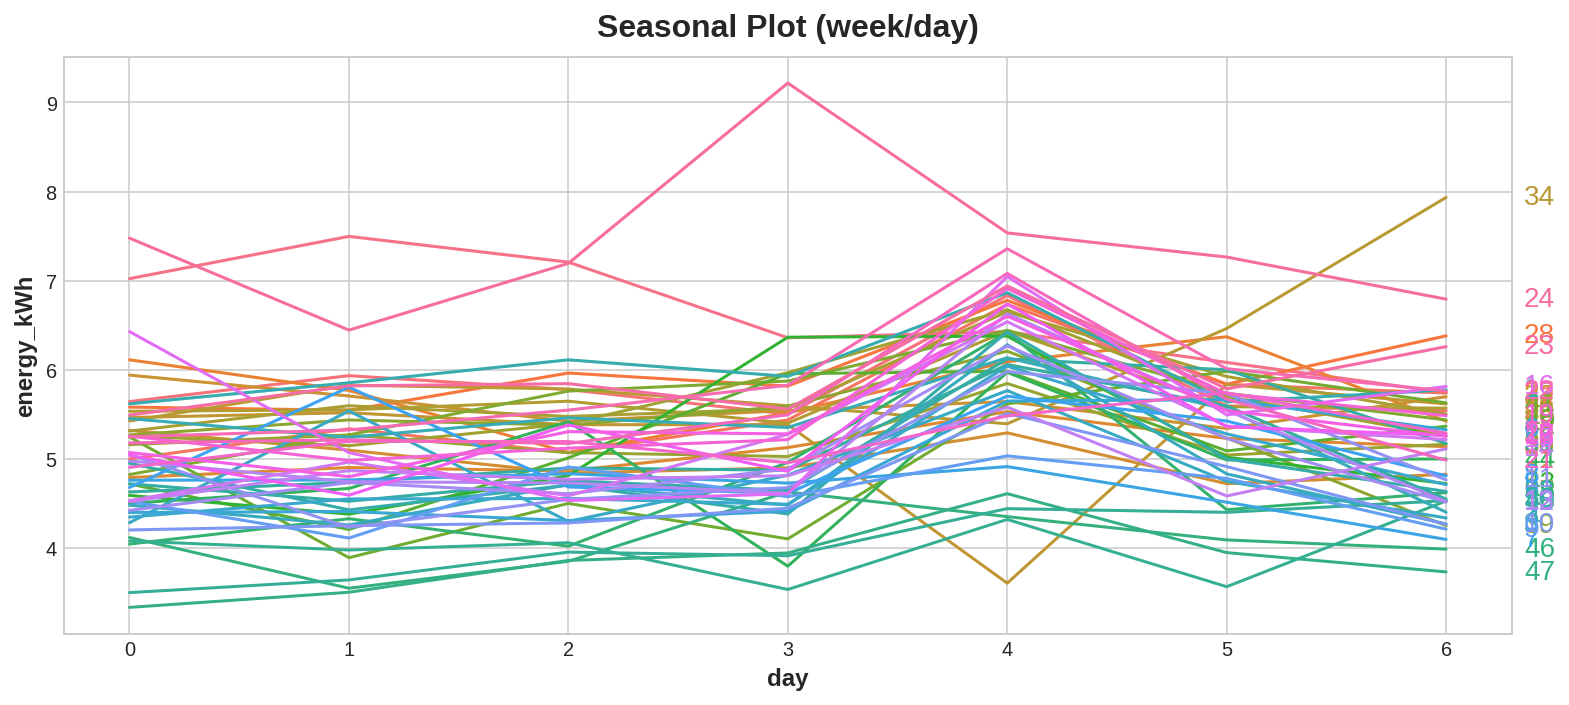

In [28]:
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y="energy_kWh", period="week", freq="day")

/tmp/ipykernel_19096/4137103328.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(X["energy_kWh"])


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

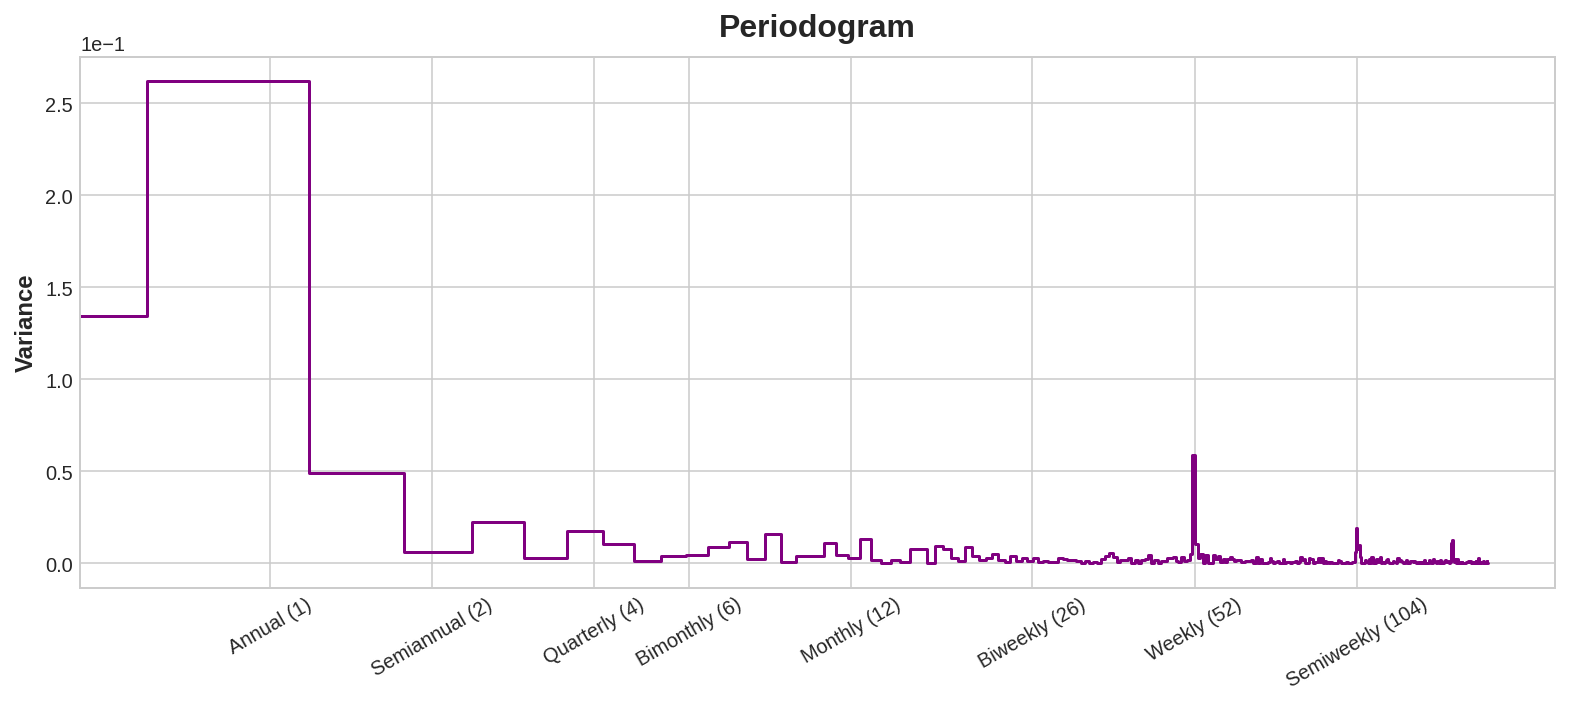

In [29]:
plot_periodogram(X["energy_kWh"])

### Evidence of weekly and semi-weekly

In [30]:
# Create the features
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

y = df_daily["energy_kWh"].copy()
y.index = df_daily.ts


fourier = CalendarFourier(freq="M", order=104) #4 sin/cos pairs for (M)onthly seasonality

dp = DeterministicProcess(
        index= y.index, 
        constant=True, # dummy for bias/y-intercept
        order=1,       # order 1 - linear trend
        
        seasonal=True, # weekly seasonality (indicators) 
        #?what makes it weekly, i.e. OHE each dayof week rather than something else?
        
        additional_terms=[fourier], # include the fourier terms we created
        drop=True) # drop terms to avoid collinearity (note this drops the Mon feature)

X = dp.in_sample() # create features

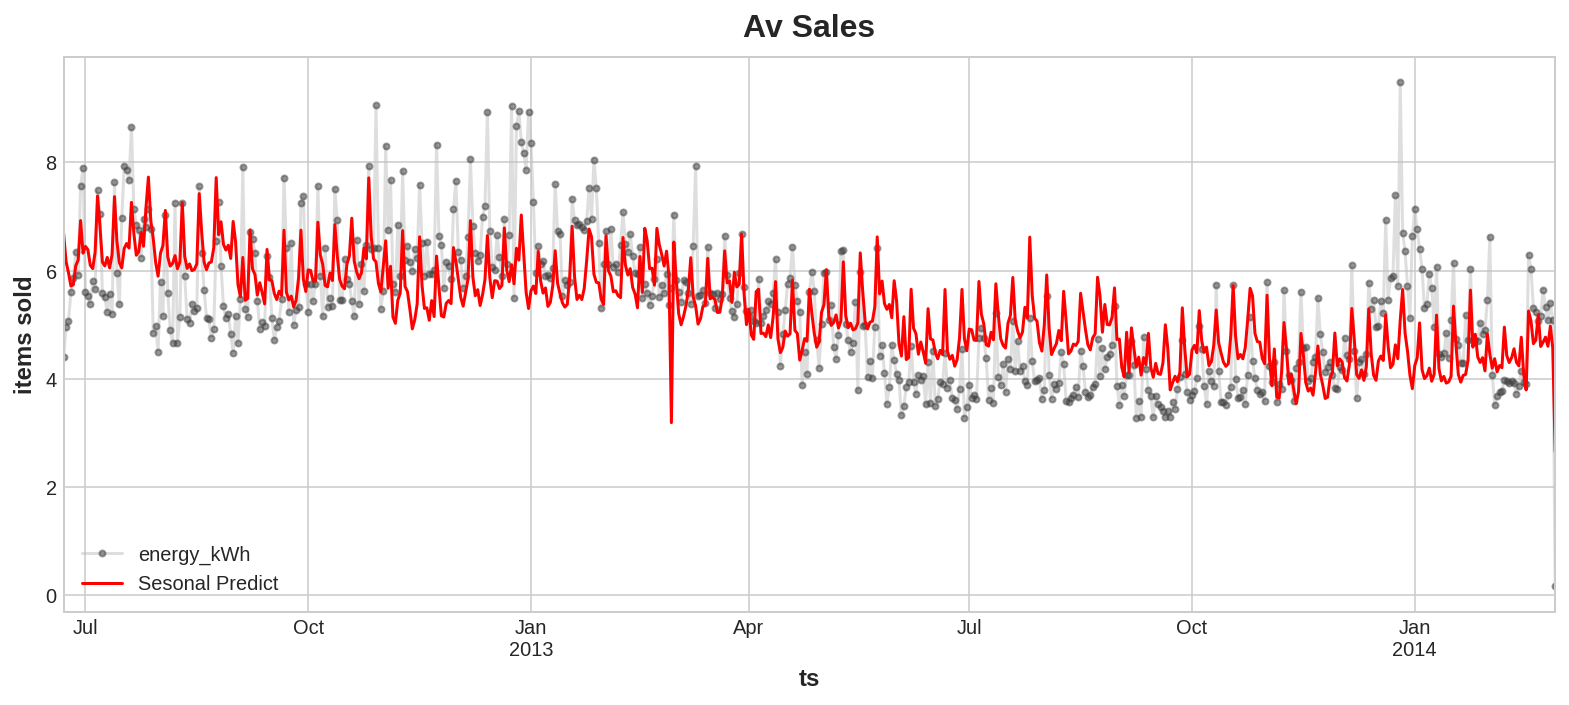

In [31]:
# Lin Reg on it

model = LinearRegression().fit(X, y)

y_pred = pd.Series(
            model.predict(X),
            index=X.index,
            name="Fitted")

ax = y.plot(**plot_params, alpha=0.5, title= "Av Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Sesonal Predict", color="r")
ax.legend()

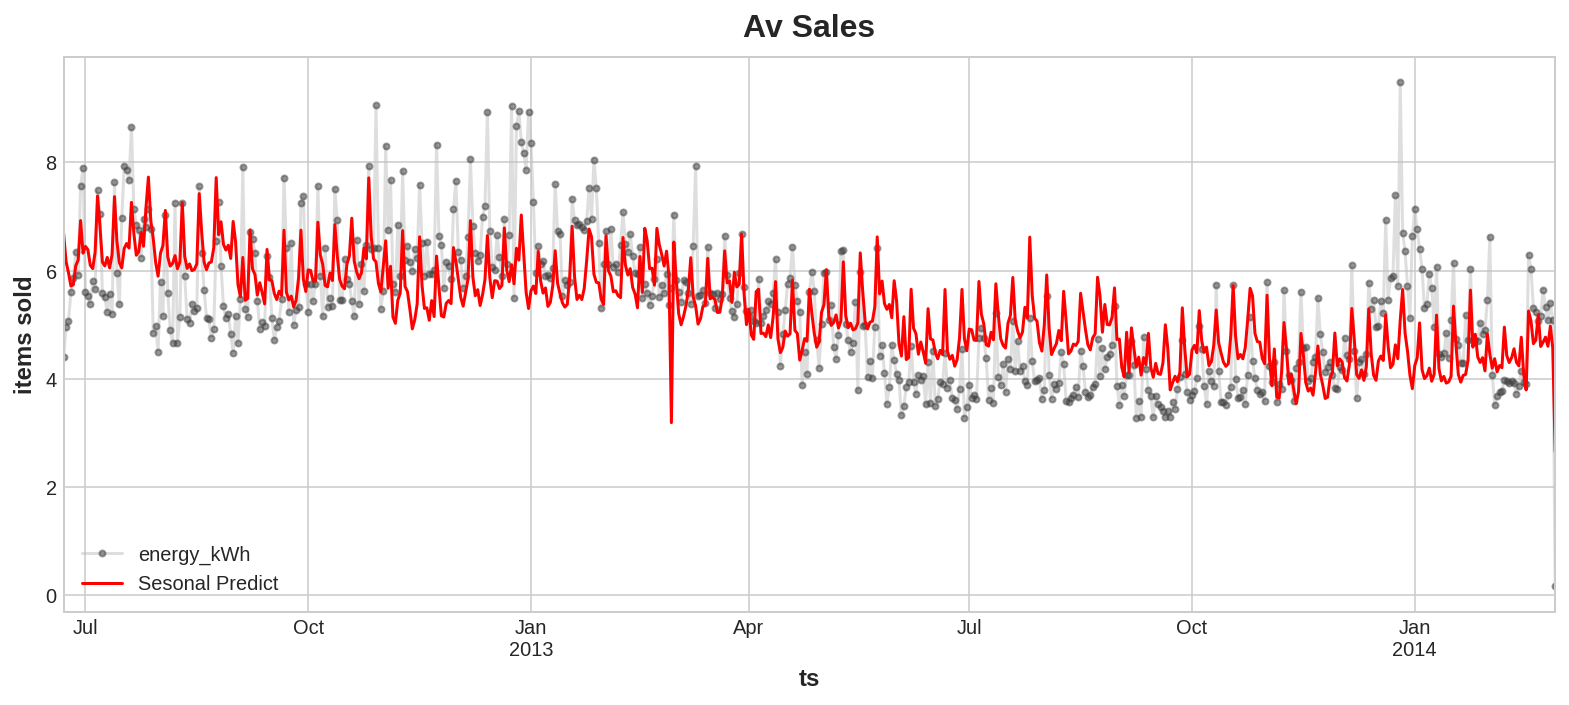

In [32]:
# Lin Reg on it

model = LinearRegression().fit(X, y)

y_pred = pd.Series(
            model.predict(X),
            index=X.index,
            name="Fitted")

ax = y.plot(**plot_params, alpha=0.5, title= "Av Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Sesonal Predict", color="r")
ax.legend()

## Start to modulise everything

In [39]:
from forecasters.seasonal import SeasonalForecast

In [40]:
# import importlib
# importlib.reload(seasonal)

In [41]:
sf = SeasonalForecast(y = df_daily["energy_kWh"].copy(),
                      idx = df_daily.ts)

In [42]:
# y_pred = sf.lin_regression_predict(freq="Y", order=52) 
#We have yearly down to weekly seasonality but this will overfit, try yrly down to monthly

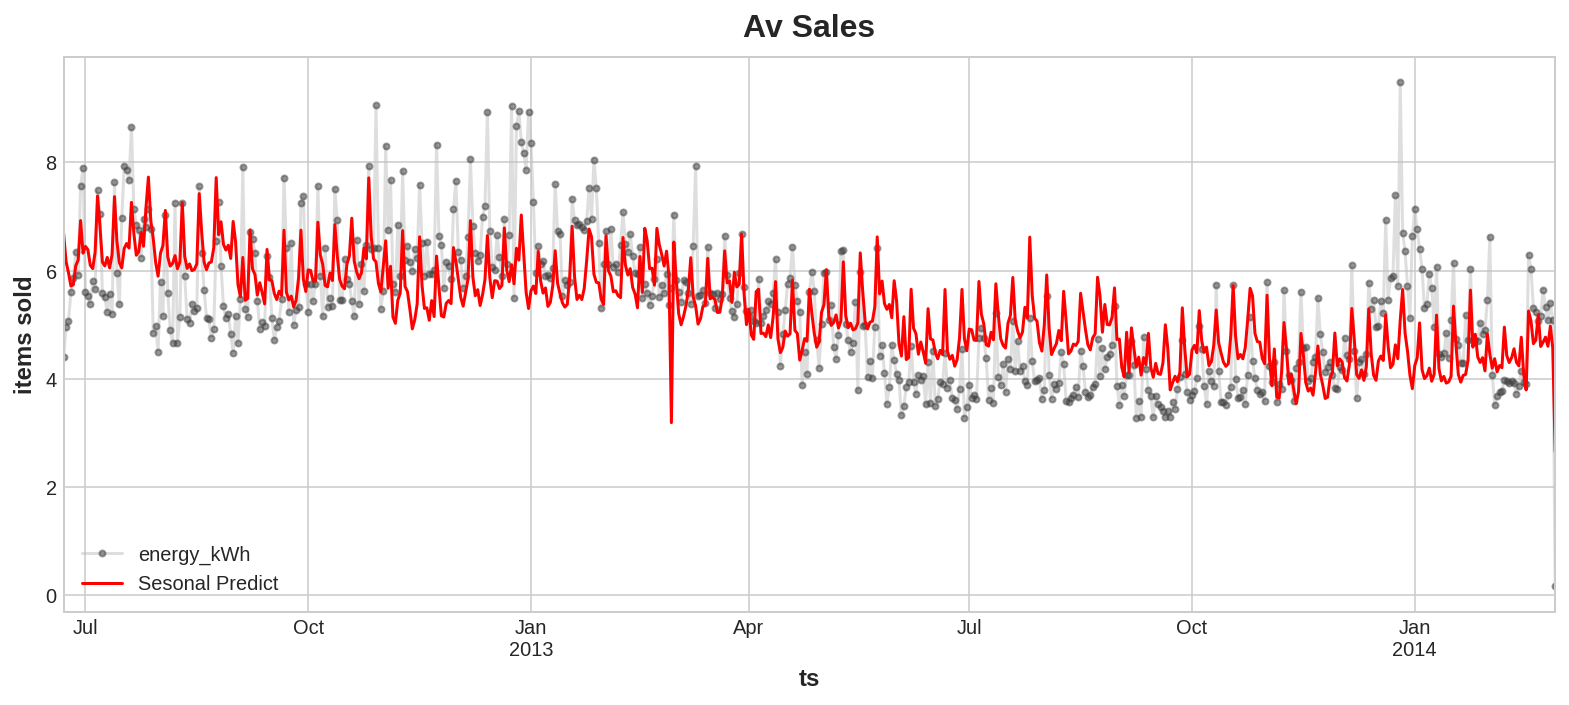

In [43]:
ax = y.plot(**plot_params, alpha=0.5, title= "Av Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Sesonal Predict", color="r")
ax.legend()

### Let's try some proper predictions (i.e. separating out train and test data)

In [44]:
y_train, y_valid = y["2012-10-01":"2013-09-30"], y["2013-10-01" :]

In [45]:
y_valid.index

DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04',
               '2013-10-05', '2013-10-06', '2013-10-07', '2013-10-08',
               '2013-10-09', '2013-10-10',
               ...
               '2014-02-19', '2014-02-20', '2014-02-21', '2014-02-22',
               '2014-02-23', '2014-02-24', '2014-02-25', '2014-02-26',
               '2014-02-27', '2014-02-28'],
              dtype='datetime64[ns]', name='ts', length=151, freq=None)

In [49]:
# import forecasters.seasonal
# import importlib
# importlib.reload(seasonal)

In [50]:
sf = SeasonalForecast(y = y_train,
                               idx = y_train.index)

In [51]:
fit_model, X_model = sf.lin_regression_fit(freq="Y", order=12)

Creating seasonal features for freq: Y and order: 12


In [52]:
# Create features for the validation set
fourier_terms_valid = CalendarFourier(freq="Y", order=12)

dp = DeterministicProcess(
     index=y_train.index,
     constant=True,  # dummy for bias/y-intercept
     order=1,  # order 1 - linear trend
     seasonal=True,
     additional_terms=[fourier_terms_valid],
     drop=True)

# create features for future steps that haven't been fit
X_model_valid = dp.out_of_sample(steps=151, forecast_index=y_valid.index)

In [53]:
y_pred = pd.Series(fit_model.predict(X_model_valid), index=X_model_valid.index)

In [54]:
y_train.index

DatetimeIndex(['2012-10-01', '2012-10-02', '2012-10-03', '2012-10-04',
               '2012-10-05', '2012-10-06', '2012-10-07', '2012-10-08',
               '2012-10-09', '2012-10-10',
               ...
               '2013-09-21', '2013-09-22', '2013-09-23', '2013-09-24',
               '2013-09-25', '2013-09-26', '2013-09-27', '2013-09-28',
               '2013-09-29', '2013-09-30'],
              dtype='datetime64[ns]', name='ts', length=365, freq=None)

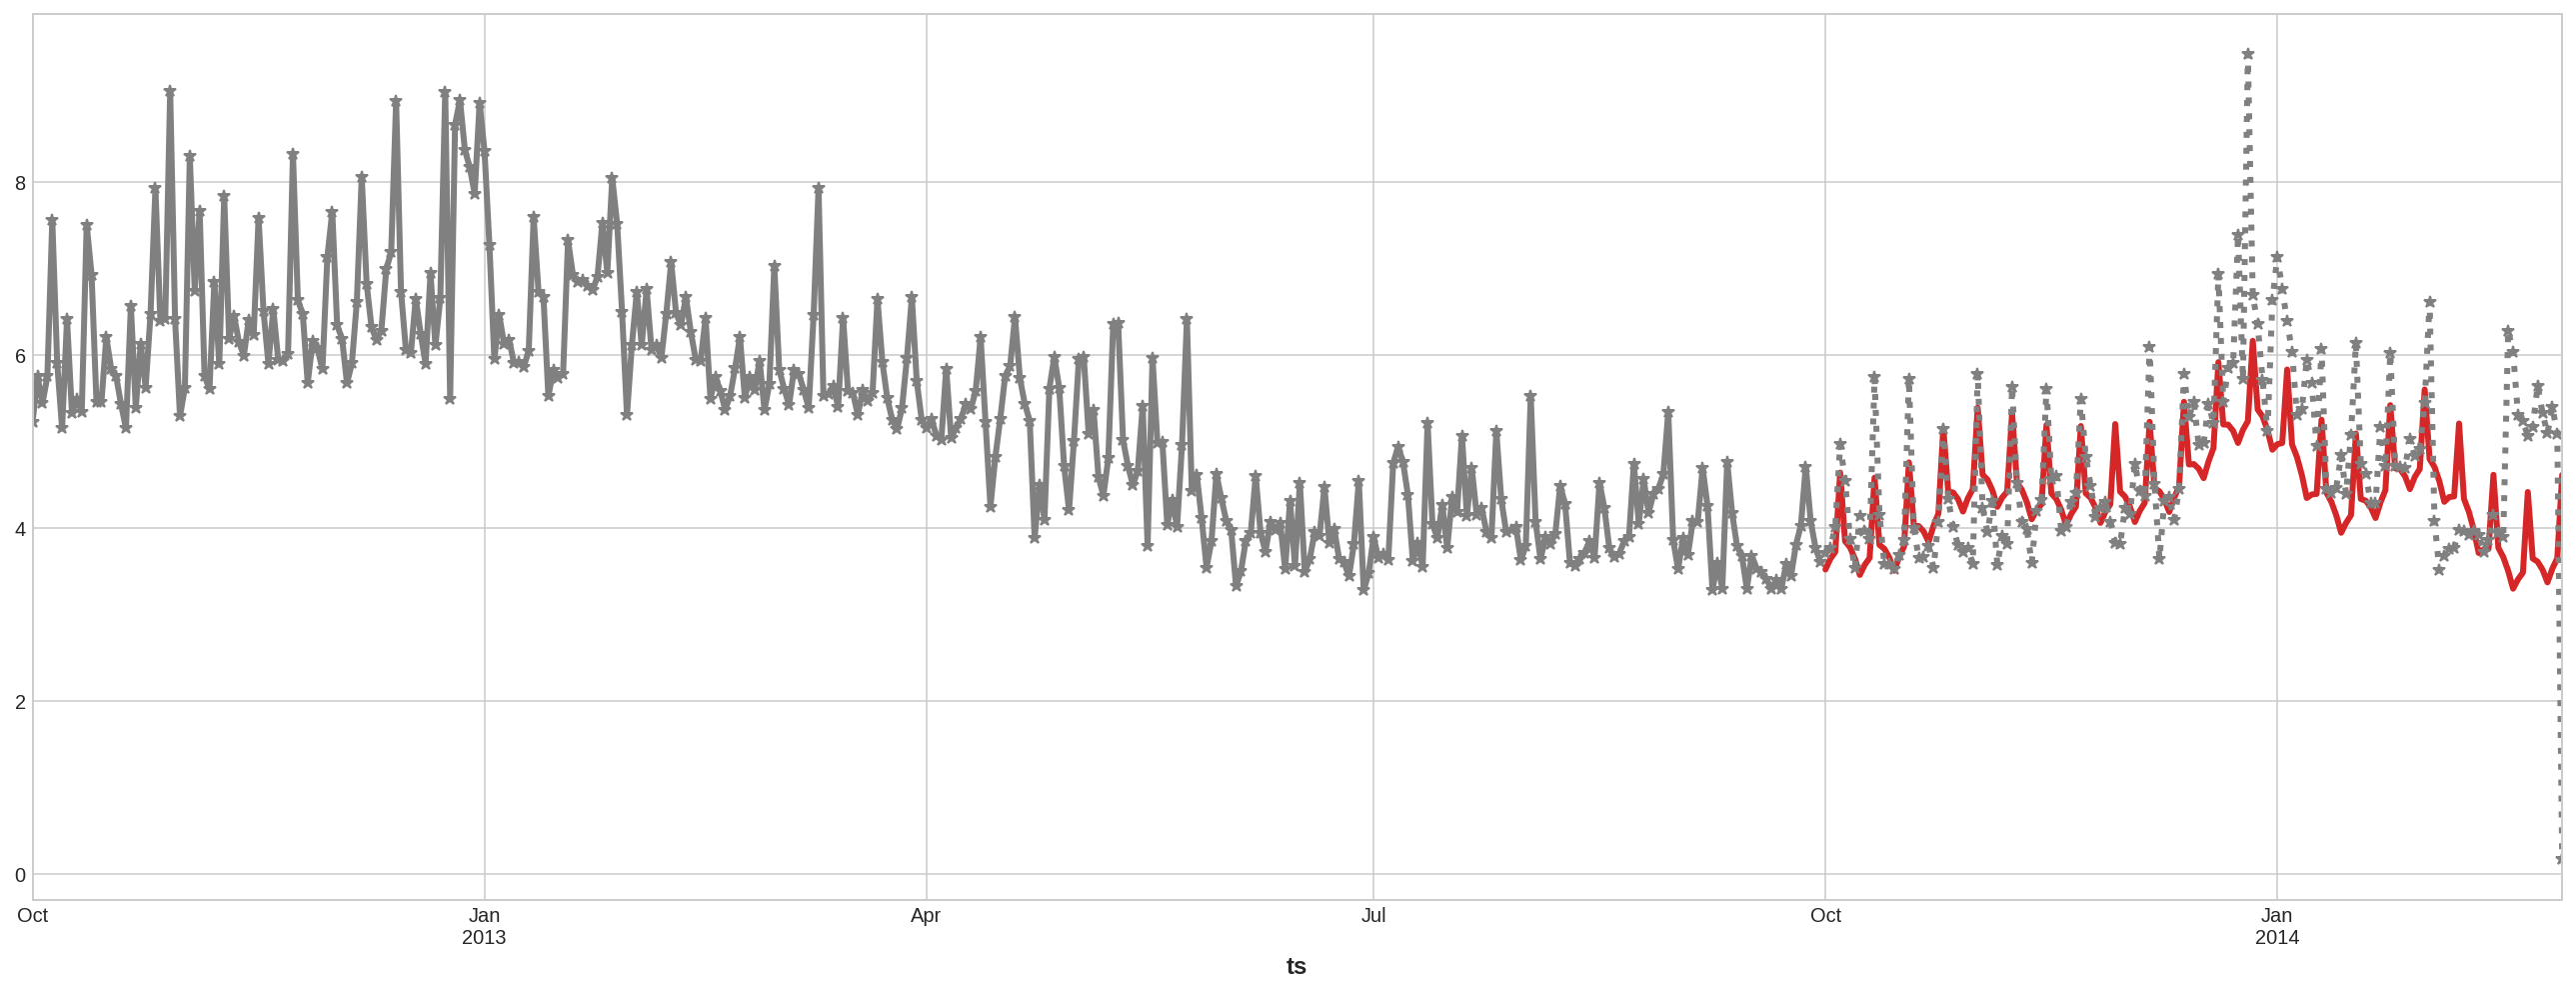

In [55]:
ax = y_train.plot(linestyle="-", marker="*", color="0.5", figsize=(18, 7),
                 linewidth=3, label="Trend")

ax = y_pred.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")

ax = y_valid.plot(linestyle=":", marker="*", color="0.5",
                 linewidth=3, label="Trend")

